In [3]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from utils.hedging import run_delta_hedge_analysis, run_delta_vega_hedge_analysis
import matplotlib.pyplot as plt

In [4]:
ticker = 'AAPL'
data = pd.read_csv(f"../data/processed/{ticker}_processed_vega.csv")

data['date'] = pd.to_datetime(data['date'])
data['expiration_date'] = pd.to_datetime(data['expiration_date'])

In [5]:
per_option = (
    data[['option_id', 'K', 'expiration_date']]
    .drop_duplicates()
)

expiries = sorted(per_option['expiration_date'].unique())
next_expiry_map = {}
for i in range(len(expiries) - 1):
    next_expiry_map[expiries[i]] = expiries[i+1]

per_option['next_expiration'] = per_option['expiration_date'].map(next_expiry_map)

In [6]:
# Left: options at T1
left = per_option.dropna(subset=['next_expiration']).copy()

# Right: potential hedge options at T2
right = per_option.rename(
    columns={
        'option_id': 'hedge_option_id',
        'expiration_date': 'hedge_expiration'
    }
)

# Merge on strike + matching T2
pairs = left.merge(
    right,
    left_on=['K', 'next_expiration'],
    right_on=['K', 'hedge_expiration'],
    how='inner'
)

# pairs now has: option_id (T1) and hedge_option_id (T2) with same K
print(pairs[['option_id', 'expiration_date', 'K',
             'hedge_option_id', 'hedge_expiration']].head())
print("Number of hedgeable options:", pairs['option_id'].nunique())


              option_id expiration_date      K       hedge_option_id  \
0  AAPL_2020-09-18_K115      2020-09-18  115.0  AAPL_2020-10-16_K115   
1  AAPL_2020-09-18_K120      2020-09-18  120.0  AAPL_2020-10-16_K120   
2  AAPL_2020-09-18_K125      2020-09-18  125.0  AAPL_2020-10-16_K125   
3  AAPL_2020-10-16_K115      2020-10-16  115.0  AAPL_2020-11-20_K115   
4  AAPL_2020-10-16_K120      2020-10-16  120.0  AAPL_2020-11-20_K120   

  hedge_expiration  
0       2020-10-16  
1       2020-10-16  
2       2020-10-16  
3       2020-11-20  
4       2020-11-20  
Number of hedgeable options: 145


In [7]:
moneness_info = (
    data[['option_id', 'initial_moneyness']]
    .drop_duplicates()
)

# merge onto pairs
pairs = pairs.merge(moneness_info, on='option_id', how='left')

# count how many *hedgeable* options per moneyness
hedgeable_counts = (
    pairs.groupby('initial_moneyness')['option_id']
         .nunique()
         .sort_index()
)

print("Hedgeable options per moneyness:")
print(hedgeable_counts)

Hedgeable options per moneyness:
initial_moneyness
ATM      8
ITM     11
OTM    126
Name: option_id, dtype: int64


## AAAAAAA

In [8]:
per_option = (
    data[['option_id', 'K', 'expiration_date']]
    .drop_duplicates()
    .copy()
)

# make sure expiration_date is datetime
per_option['expiration_date'] = pd.to_datetime(per_option['expiration_date'])

expiries = sorted(per_option['expiration_date'].unique())

# map T1 → T2
next_expiry_map = {
    expiries[i]: expiries[i+1]
    for i in range(len(expiries) - 1)
}

per_option['next_expiration'] = per_option['expiration_date'].map(next_expiry_map)

# Left = target option (shorter maturity)
left = per_option.dropna(subset=['next_expiration']).copy()

# Right = hedge option (longer maturity), rename for clarity
right = per_option.rename(columns={
    'option_id': 'hedge_option_id',
    'expiration_date': 'hedge_expiration'
})

pairs = left.merge(
    right,
    left_on=['K', 'next_expiration'],
    right_on=['K', 'hedge_expiration'],
    how='inner'
)

# to see how many hedgeable options exist per moneyness
moneness_info = (
    data[['option_id', 'initial_moneyness']]
    .drop_duplicates()
)

pairs = pairs.merge(moneness_info, on='option_id', how='left')

print(pairs['initial_moneyness'].value_counts())


initial_moneyness
OTM    126
ITM     11
ATM      8
Name: count, dtype: int64


In [9]:
frequencies = [1, 2, 3, 7]

delta_vega_summary = run_delta_vega_hedge_analysis(
    data=data,
    pairs=pairs,
    frequencies=frequencies
)


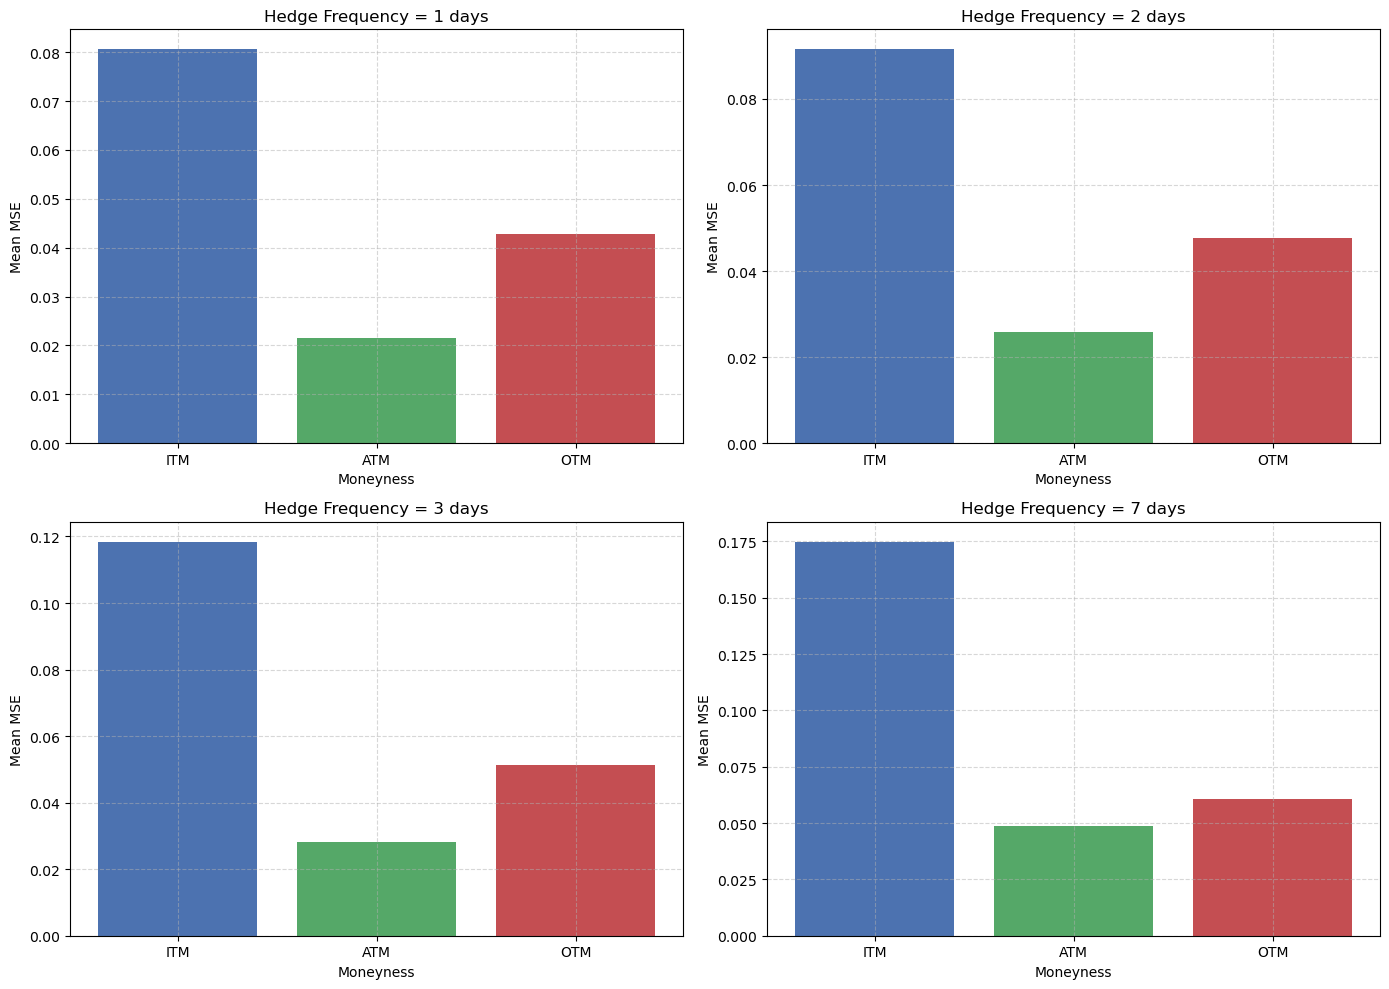

In [10]:
# Use this depending on your summary source:
df = delta_vega_summary   # or delta_summary

# Define order
frequencies = [1, 2, 3, 7]
moneyness_levels = ["ITM", "ATM", "OTM"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, freq in enumerate(frequencies):
    ax = axes[idx]

    # Filter data for this frequency
    d = df[df['hedge_frequency'] == freq]

    # Compute mean MSE per moneyness
    means = (
        d.groupby("initial_moneyness")['mse']
        .mean()
        .reindex(moneyness_levels)
    )

    # Plot bar chart
    ax.bar(moneyness_levels, means.values, color=["#4C72B0", "#55A868", "#C44E52"])

    ax.set_title(f"Hedge Frequency = {freq} days")
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Mean MSE")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()